# Восстановление золота из руды

Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Предоставлены данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### Цель

Создать модель, предсказывающую коэффициент восстановления золота из золотосодержащей руды. 

### Задачи

1. Подготовить данные
2. Проанализировать данные
3. Построить модель

### Технологический процесс

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

**Флотация.** Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

**Очистка.** Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Описание данных

**Технологический процесс**

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate — ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

### Наименование признаков

Наименование признаков:  
<code>[этап].[тип_параметра].[название_параметра]</code>  
Пример: <code>rougher.input.feed_ag</code>    
Возможные значения для блока <code>[этап]</code>:    
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  
Возможные значения для блока <code>[тип_параметра]</code>:    
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики  

### Расчет эффективности

Эффективность обогащения рассчитывается по формуле

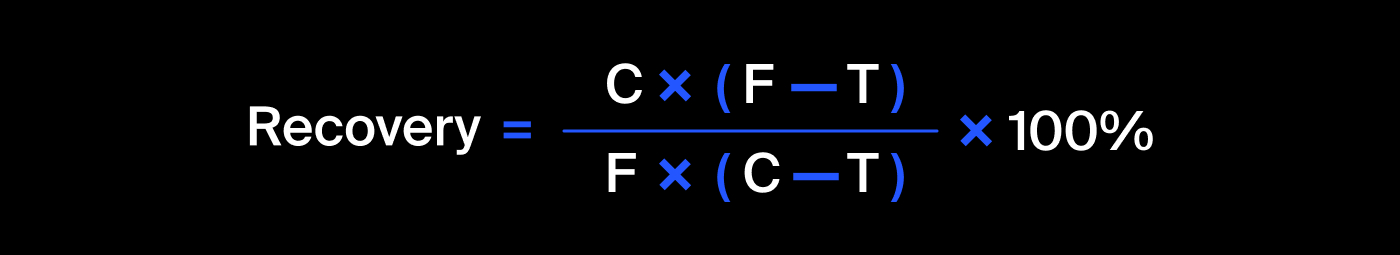

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

### Метрика качества

Для решения задачи выберем метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

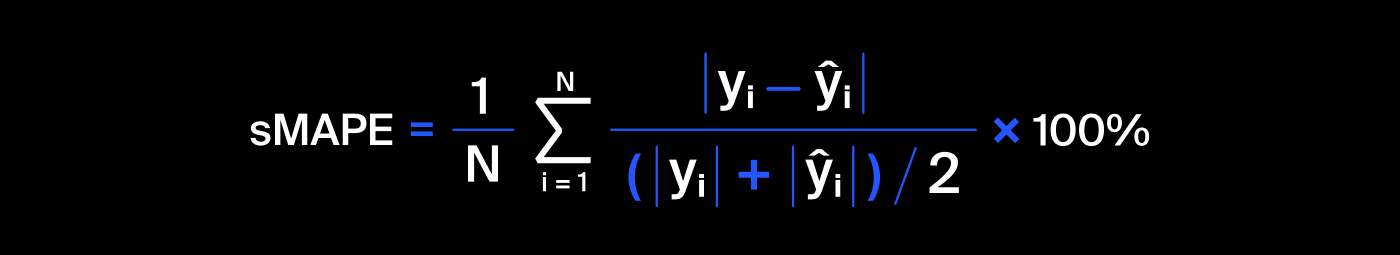

Нужно спрогнозировать сразу две величины:

1. Эффективность обогащения чернового концентрата rougher.output.recovery;
2. Эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

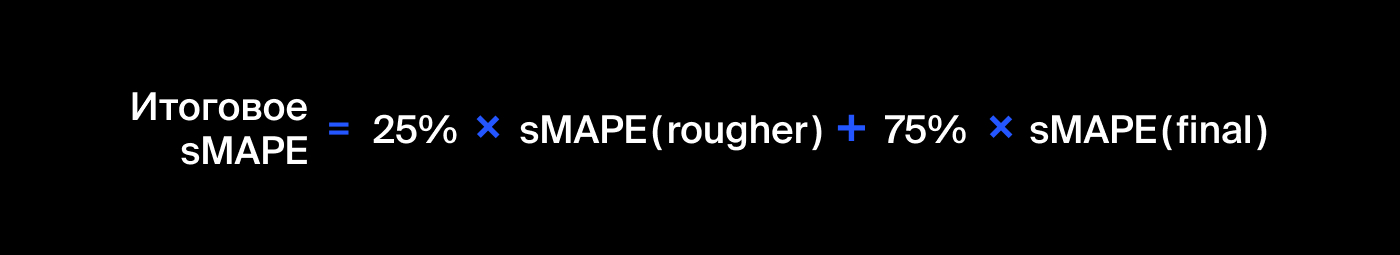

### Данные

* <code>gold_recovery_train_new.csv</code> — обучающая выборка;
* <code>gold_recovery_test_new.csv</code> — тестовая выборка;
* <code>gold_recovery_full_new.csv</code> — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.  



Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.  

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, make_scorer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (cross_val_score, GridSearchCV)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics._scorer import make_scorer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
from sklearn.dummy import DummyRegressor
# настройки
warnings.filterwarnings("ignore")

Загружаем данные

In [2]:
try:
    data_full = pd.read_csv('gold_recovery_full_new.csv')
    data_train = pd.read_csv('gold_recovery_train_new.csv')
    data_test = pd.read_csv('gold_recovery_test_new.csv')
except:
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

Изучим данные

In [3]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Проверим, что эффективность обогащения расчитана правильно

In [5]:
# функция для получения эффективности обогащения чернового концентрата. Возвращает pd.Series
def get_rougher_recovery(data):
    C = data['rougher.output.concentrate_au'] # доля золота в концентрате после флотации;
    F = data['rougher.input.feed_au'] # доля золота в сырье до флотации;
    T = data['rougher.output.tail_au'] # доля золота в отвальных хвостах после флотации.
    recovery = C*(F-T)/(F*(C-T)) # эффективность обогащения
    return recovery * 100 # в %-х

In [6]:
train_rougher_recovery = get_rougher_recovery(data_train) # эффективность обогащения чернового концентрата для обучающей выборки

Найдем MAE между расчетами и значением признака

In [7]:
mean_absolute_error(train_rougher_recovery, data_train['rougher.output.recovery'])

9.73512347450521e-15

Получили число, практически равное нулю, что говорит о правильности значений эффективности обогащения, указанных в таблице.

Изучим тестовую выборку, проанализируем признаки, недоступные в тестовой выборке.

In [8]:
data_test[:1]

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.31785,4.872511,-500.037437,26.705889,-499.709414


In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Получаем, что в тестовой выборке на 34 признака меньше.

In [10]:
len(set(data_train.columns)&set(data_test.columns))

53

In [11]:
len(set(data_train.columns)|set(data_test.columns))

87

Получаем, что все признаки, присутствующие в тестовой выборке, присутствуют и в обучающей, при этом в тестовой выборке недостает 34 признака. Рассмотрим отсутствующие признаки.

In [12]:
print(list(set(data_train.columns) - set(data_test.columns)))

['primary_cleaner.output.concentrate_sol', 'secondary_cleaner.output.tail_pb', 'rougher.output.recovery', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.tail_pb', 'rougher.output.concentrate_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'final.output.recovery', 'final.output.concentrate_pb', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'secondary_cleaner.output.tail_au', 'primary_cleaner.output.tail_sol', 'rougher.output.tail_ag', 'secondary_cleaner.output.tail_ag', 'rougher.calculation.au_pb_ratio', 'primary_cleaner.output.concentrate_pb', 'rougher.output.tail_au', 'final.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.tail_sol', 'final.output.tail_pb', 'primary_cleaner.output.concentrate_au', 'rougher.output.tail_pb', 'final.output.tai

В тестовой выборке отстутствуют типы параметров *output* и *calculation*. Из задания мы знаем, что эти параметры замеряются или расчитываются значительно позже. Также в тестовом наборе нет целевых признаков. 

Так как модель в тесте будет делать предсказания, основываясь на тестовой выборке, при обучении модели следует использовать только признаки, присутствующие в тестовой выборке.

**Проведем предобработку данных**

In [13]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Во многих столбцах есть небольшое количество пропущенных данных

In [14]:
data_train[data_train.isna()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Возможно, пропущенные данные обозначают отсутствие какго-либо компонента. Тогда вместо них можно было бы поставить 0.

In [15]:
data_train[data_train['primary_cleaner.input.depressant'] == 0].shape[0]

10

Как видим, отсутствие депрессанта обозначается нулем, из чего можно сделать вывод, что предположение оказалось неверным. 

Для обеспечения возможности обучения модели удалим строки с отсутствующими данными.

In [16]:
data_train_preprocessed = data_train.dropna(axis='index')

In [17]:
data_train_preprocessed['date'] = pd.to_datetime(data_train_preprocessed['date'])

In [18]:
data_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                11017 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         11017 non-null  float64       
 2   final.output.concentrate_pb                         11017 non-null  float64       
 3   final.output.concentrate_sol                        11017 non-null  float64       
 4   final.output.concentrate_au                         11017 non-null  float64       
 5   final.output.recovery                               11017 non-null  float64       
 6   final.output.tail_ag                                11017 non-null  float64       
 7   final.output.tail_pb                                11017 non-null  float64       
 8   final.

Преобразуем тестовую выборку

In [19]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [20]:
data_test_preproccesed = data_test.dropna(axis='index')

In [21]:
data_test_preproccesed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5229 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5229 non-null   object 
 1   primary_cleaner.input.sulfate               5229 non-null   float64
 2   primary_cleaner.input.depressant            5229 non-null   float64
 3   primary_cleaner.input.feed_size             5229 non-null   float64
 4   primary_cleaner.input.xanthate              5229 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5229 non-null   float64
 10  primary_clea

In [22]:
data_test_preproccesed['date'] = pd.to_datetime(data_test_preproccesed['date'])

Будем использовать столбец "date" как индекс, чтобы удобнее связывать данные в выборках

In [23]:
data_test_preproccesed.set_index('date', inplace=True)

In [24]:
data_train_preprocessed.set_index('date', inplace=True)

In [25]:
data_full['date'] = pd.to_datetime(data_full['date'])

In [26]:
data_full.set_index('date', inplace=True)

Добавим в тестовую выборку столбцы с целевыми признаками. Данные возьмем из полной выборки.

In [27]:
data_test_preproccesed = data_test_preproccesed.join(data_full['rougher.output.recovery'])
data_test_preproccesed = data_test_preproccesed.join(data_full['final.output.recovery'])

In [28]:
data_test_preproccesed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5229 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5229 non-null   float64
 1   primary_cleaner.input.depressant            5229 non-null   float64
 2   primary_cleaner.input.feed_size             5229 non-null   float64
 3   primary_cleaner.input.xanthate              5229 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5229 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5229 

## Анализ данных

Посмотрим, как меняется **концентрация металлов на различных этапах очистки**. 

**Для золота получаем**

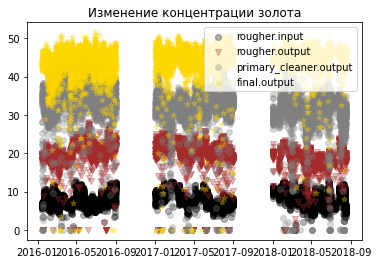

In [29]:
fig, ax = plt.subplots()

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['rougher.input.feed_au'], 
c = 'black', alpha = 0.3, marker = 'o', label='rougher.input')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['rougher.output.concentrate_au'], 
c = 'brown', alpha = 0.3, marker = 'v', label='rougher.output')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['primary_cleaner.output.concentrate_au'], 
c = 'grey', alpha = 0.3, marker = '8', label='primary_cleaner.output')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['final.output.concentrate_au'], 
c = 'gold', alpha = 0.3, marker = '*', label='final.output')

ax.set_title('Изменение концентрации золота')
ax.legend();


На графике видно, что с каждым последующим этапом очистки концентрация золота растет.

**Для серебра получаем**

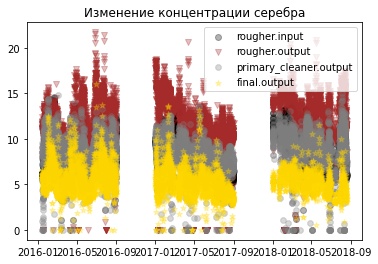

In [30]:
fig, ax = plt.subplots()

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['rougher.input.feed_ag'], 
c = 'black', alpha = 0.3, marker = 'o', label='rougher.input')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['rougher.output.concentrate_ag'], 
c = 'brown', alpha = 0.3, marker = 'v', label='rougher.output')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['primary_cleaner.output.concentrate_ag'], 
c = 'grey', alpha = 0.3, marker = '8', label='primary_cleaner.output')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['final.output.concentrate_ag'], 
c = 'gold', alpha = 0.3, marker = '*', label='final.output')

ax.set_title('Изменение концентрации серебра')
ax.legend();

Судя по графику, после флотации концентрация серебра увеличивается. Затем, после первого и второго этапов очистки, концентрация серебра уменьшается. 

**Для свинца получаем**

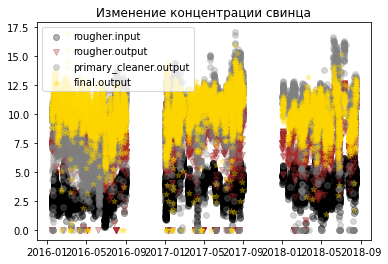

In [31]:
fig, ax = plt.subplots()

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['rougher.input.feed_pb'], 
c = 'black', alpha = 0.3, marker = 'o', label='rougher.input')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['rougher.output.concentrate_pb'], 
c = 'brown', alpha = 0.3, marker = 'v', label='rougher.output')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['primary_cleaner.output.concentrate_pb'], 
c = 'grey', alpha = 0.3, marker = '8', label='primary_cleaner.output')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['final.output.concentrate_pb'], 
c = 'gold', alpha = 0.3, marker = '*', label='final.output')

ax.set_title('Изменение концентрации свинца')
ax.legend();

Концентрация свинца увеличивается после флотации и после первого этапа очистки. После второго этапа очистки его концентрация значительно не изменяется.

**Для sol получаем**

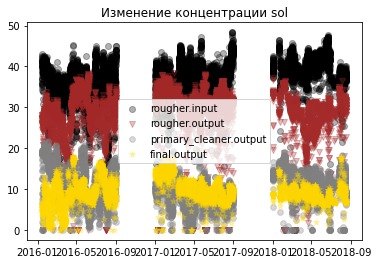

In [32]:
fig, ax = plt.subplots()

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['rougher.input.feed_sol'], 
c = 'black', alpha = 0.3, marker = 'o', label='rougher.input')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['rougher.output.concentrate_sol'], 
c = 'brown', alpha = 0.3, marker = 'v', label='rougher.output')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['primary_cleaner.output.concentrate_sol'], 
c = 'grey', alpha = 0.3, marker = '8', label='primary_cleaner.output')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed['final.output.concentrate_sol'], 
c = 'gold', alpha = 0.3, marker = '*', label='final.output')

ax.set_title('Изменение концентрации sol')
ax.legend();

Концентрация sol уменьшается после каждого этапа очистки.

Сравним **распределения размеров гранул сырья** на обучающей и тестовой выборках, т.к., если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

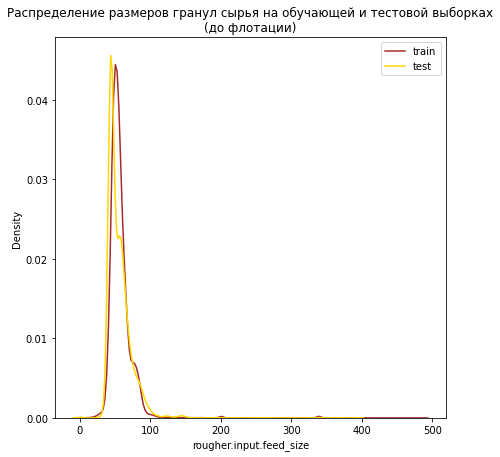

In [33]:
plt.figure(figsize=(7, 7))
sns.kdeplot(data_train_preprocessed['rougher.input.feed_size'], color='brown', label='train')
sns.kdeplot(data_test_preproccesed['rougher.input.feed_size'], color='gold', label='test')
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках\n(до флотации)');
plt.legend();

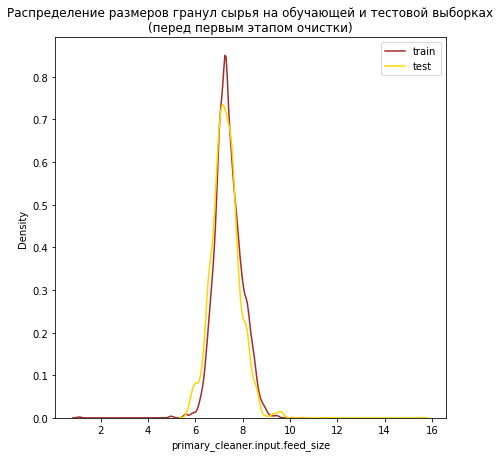

In [34]:
plt.figure(figsize=(7, 7))
sns.kdeplot(data_train_preprocessed['primary_cleaner.input.feed_size'], color='brown', label='train')
sns.kdeplot(data_test_preproccesed['primary_cleaner.input.feed_size'], color='gold', label='test')
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках\n(перед первым этапом очистки)');
plt.legend();

Графики показали, что плотности распределения размеров гранул для обучающей и тестовой выборок отличаются незначительно, поэтому данный фактор не должен существенно повлиять на правильность оценки модели.

Посмотрим, как меняется **суммарная концентрация всех веществ** на разных стадиях.

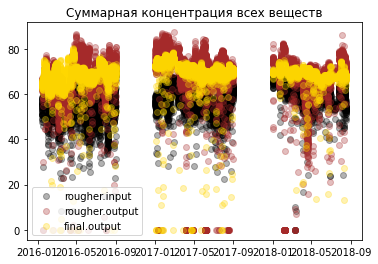

In [35]:
fig, ax = plt.subplots()

ax.scatter(data_train_preprocessed.index, data_train_preprocessed.loc[:, [
    'rougher.input.feed_au', 'rougher.input.feed_ag','rougher.input.feed_pb',
    'rougher.input.feed_sol']].sum(axis='columns'), 
c = 'black', alpha = 0.3, marker = 'o', label='rougher.input')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed.loc[:, [
    'rougher.output.concentrate_au', 'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb','rougher.output.concentrate_sol']].sum(axis='columns'), 
c = 'brown', alpha = 0.3, marker = 'o', label='rougher.output')

ax.scatter(data_train_preprocessed.index, data_train_preprocessed.loc[:, [
    'final.output.concentrate_au', 'final.output.concentrate_ag',
    'final.output.concentrate_pb','final.output.concentrate_sol']].sum(axis='columns'), 
c = 'gold', alpha = 0.3, marker = 'o', label='final.output')

ax.set_title('Суммарная концентрация всех веществ')
ax.legend();

Получаем, что суммарная концентрация всех веществ увеличивается после флотации и практически не изменяется после очистки. Учитывая, что концентрация золота увеличивается после каждого этапа, можем сделать вывод, что суммарная концентрация остальных веществ уменьшается после первого и второго этапов очистки.

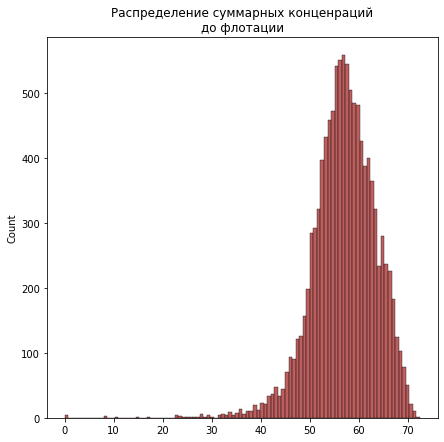

In [36]:
plt.figure(figsize=(7, 7))
sns.histplot(data_train_preprocessed.loc[:,[
    'rougher.input.feed_au', 'rougher.input.feed_ag','rougher.input.feed_pb',
    'rougher.input.feed_sol']].sum(axis='columns'), color='brown')
plt.title('Распределение суммарных конценраций\nдо флотации');

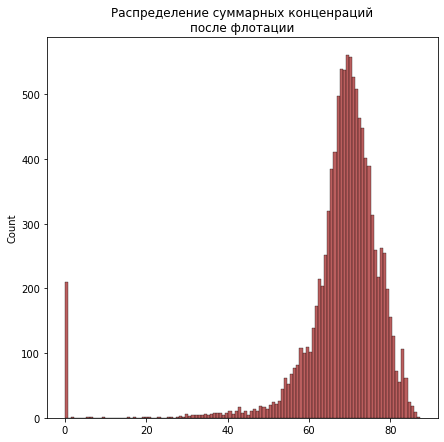

In [37]:
plt.figure(figsize=(7, 7))
sns.histplot(data_train_preprocessed.loc[:,[
    'rougher.output.concentrate_au', 'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb','rougher.output.concentrate_sol']].sum(axis='columns'), color='brown')
plt.title('Распределение суммарных конценраций\nпосле флотации');

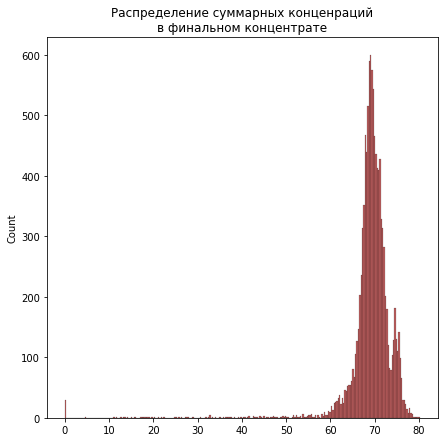

In [38]:
plt.figure(figsize=(7, 7))
sns.histplot(data_train_preprocessed.loc[:,[
    'final.output.concentrate_au', 'final.output.concentrate_ag',
    'final.output.concentrate_pb','final.output.concentrate_sol']].sum(axis='columns'), color='brown')
plt.title('Распределение суммарных конценраций\nв финальном концентрате');

На гистограммах распределения суммарных концентраций наблюдаются аномалии суммарной концентрации, что говорит о вероятной неточности в измерениях. Следует убрать выбивающиеся данные из обучающей выборки.

Уберем аномалии по первому графику

In [39]:
data_train_preprocessed.shape[0]

11017

In [40]:
data_train_preprocessed = data_train_preprocessed[data_train_preprocessed.loc[:,[
    'rougher.input.feed_au', 'rougher.input.feed_ag','rougher.input.feed_pb',
    'rougher.input.feed_sol']].sum(axis='columns') >= -10]

Уберем аномалии по второму графику

In [41]:
data_train_preprocessed = data_train_preprocessed[data_train_preprocessed.loc[:,[
    'rougher.output.concentrate_au', 'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb','rougher.output.concentrate_sol']].sum(axis='columns') >= -5]

Уберем аномалии по третьему графику

In [42]:
data_train_preprocessed = data_train_preprocessed[data_train_preprocessed.loc[:,[
    'final.output.concentrate_au', 'final.output.concentrate_ag',
    'final.output.concentrate_pb','final.output.concentrate_sol']].sum(axis='columns') >= -5]

In [43]:
data_train_preprocessed.shape[0]

11017

Теперь, если обновить графики распределения, можно убедиться в отсутствии выбросов в суммарной концентрации.

## Модель

Выполним **масштабирование данных**

In [44]:
# создаём скелер
scaler = StandardScaler()

Создадим переменную для масштабированной обучающей выборки

In [45]:
scaled_data_train = data_train_preprocessed[data_test_preproccesed.columns].copy()

Чтобы избежать масштабирования целевых признаков, используем набор обучающих признаков без таргетов. 

In [46]:
sc_features = scaled_data_train.columns.drop(['rougher.output.recovery', 'final.output.recovery'])

In [47]:
# обучаем скелер на численных признаках тренировочной выборки
scaler.fit(scaled_data_train[sc_features])

StandardScaler()

In [48]:
# трансформируем её же
scaled_data_train[sc_features] = scaler.transform(scaled_data_train[sc_features])

In [49]:
scaled_data_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,-0.367857,0.232132,-0.253847,0.263598,-0.439751,-0.299391,-0.437737,-0.805158,-0.428123,-0.273942,...,-0.543467,-0.801519,-1.117141,-0.404191,-0.797167,-0.437365,-1.068253,-2.454879,87.107763,70.541216
2016-01-15 01:00:00,-0.408223,0.281835,-0.253847,0.301810,-0.238558,-0.357471,-0.252873,-0.320408,-0.234517,-0.292470,...,-0.571163,-0.745417,-1.097719,-0.449986,-0.813353,-0.440020,-1.095601,-2.302048,86.843261,69.266198
2016-01-15 02:00:00,-0.458156,0.583692,-0.253847,0.270486,-0.044999,-0.331032,-0.068614,-0.342154,-0.041732,-0.336896,...,-0.578161,-0.742132,-1.092305,-0.448980,-0.808387,-0.438477,-1.090183,-2.343448,86.842308,68.116445
2016-01-15 03:00:00,-0.500919,0.585426,-0.253847,0.285528,-0.057101,-0.358835,-0.066559,-0.314874,-0.054329,-0.332837,...,-0.562076,-0.743132,-1.109494,-0.426142,-0.814621,-0.432230,-1.094314,-2.307322,87.226430,68.347543
2016-01-15 04:00:00,-0.619085,0.760460,-0.253847,0.321615,-0.046649,-0.301237,-0.060688,-0.333814,-0.059682,-0.337413,...,-0.570693,-0.740814,-1.117129,-0.487334,-0.828790,-0.434621,-1.095906,-2.345198,86.688794,66.927016


Создадим отдельную переменную для масштабированной тестовой выборки.

In [50]:
scaled_data_test = data_test_preproccesed.copy()

In [51]:
# трансформируем её же
scaled_data_test[sc_features] = scaler.transform(scaled_data_test[sc_features])

In [52]:
scaled_data_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,1.942165,1.671775,1.188903,0.308291,-1.589346,-0.337670,-1.586063,-0.321986,-1.538243,-0.332162,...,-1.300441,-0.744714,-1.455476,1.220793,-1.344121,-0.427014,1.175984,0.224057,89.993421,70.273583
2016-09-01 01:59:59,2.068873,1.670104,1.188903,0.268298,-1.590897,-0.332770,-1.594279,-0.317837,-1.567535,-0.290329,...,-1.279248,-0.717281,-1.453474,-1.082071,-1.343040,-0.429997,0.874606,0.221280,88.089657,68.910432
2016-09-01 02:59:59,2.065216,1.047902,0.679015,0.283616,-1.593064,-0.356404,-1.588208,-0.317437,-1.553269,-0.373508,...,-1.285567,-0.737060,-1.434193,-0.465541,-1.338559,-0.422026,0.870123,0.201008,88.412756,68.143213
2016-09-01 03:59:59,2.067321,0.788038,0.424071,-0.080611,-1.584491,-0.297976,-1.598918,-0.301213,-1.538048,-0.265064,...,-1.289635,-0.714632,-1.463934,-0.467186,-1.334078,-0.425252,0.861910,0.249284,87.360133,67.776393
2016-09-01 04:59:59,1.619249,0.396147,0.232864,-0.239845,-1.571912,-0.354653,-1.593725,-0.309816,-1.522906,-0.335198,...,-1.293393,-0.729934,-1.427896,-0.680385,-1.329597,-0.434716,0.871637,0.195108,83.236367,61.467078


Напишем функцию для вычисления sMAPE.

In [53]:
def smape(y_true,y_pred):
    return (np.abs(y_true-y_pred)/(np.abs(y_true)+np.abs(y_pred))*2).sum()/y_true.shape[0]*100

Создадим scorer sMAPE

In [54]:
smape_scorer = make_scorer(smape, greater_is_better=False)

Функция для вычисления итоговой sMAPE

In [55]:
def final_smape(smape_rougher,smape_final):
     return 0.25*smape_rougher+0.75*smape_final

### Первый целевой признак

Для обучения оставим в обучающей выборке только те признаки, которые есть в тестовой выборке.

In [56]:
target = scaled_data_train['rougher.output.recovery'] 
features = scaled_data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis='columns') 

**Модель линейной регрессии**

Для оценки качества моделей будем использовать кросс-валидацию.

In [57]:
linear_scores = []

# зададим размер блока, если их всего пять
sample_size = int(len(features)/5)

for i in range(0, len(features), sample_size):
    if i+sample_size > len(features): # индексы не должны быть больше размеров выборки
        break
    valid_indexes = [x for x in range(i, i+sample_size)]# индексы для валидационного блока 
    train_indexes = [x for x in range(0,i)]+[x for x in range(i+sample_size, len(features))]# индексы для обучающей выборки 
    features_train = features.iloc[train_indexes]
    target_train = target.iloc[train_indexes] 
    features_valid = features.iloc[valid_indexes]
    target_valid = target.iloc[valid_indexes]

    model = LinearRegression()
    model = model.fit(features_train, target_train)
    predictions = model.predict(features_valid)

    score = smape(target_valid, predictions)#  оценка качества модели с помощью sMAPE
    
    linear_scores.append(score)

In [58]:
linear_scores

[11.963790578721854,
 8.243367073772767,
 12.574441933702959,
 16.10990878832431,
 10.659961066673189]

Среднее значение sMAPE

In [59]:
np.mean(linear_scores)

11.910293888239016

Выполним кросс-валидацию с помошью cross-val_score

In [60]:
model = LinearRegression()
scores = cross_val_score(model, features, target, cv=5, scoring=smape_scorer)

In [61]:
scores

array([-11.95921451,  -8.24091582, -12.5836109 , -16.11698478,
       -10.72599196])

In [62]:
np.mean(scores)

-11.925343594602724

Обоими способами **среднее значение sMAPE для линейной регрессии получилось равным около 11,92%**

**Модель регрессии случайного леса**

In [63]:
forest_model = RandomForestRegressor(random_state=12345)

Создаем GridSearchCV объект

In [64]:
GS = GridSearchCV(estimator = forest_model,
                  param_grid = {'max_depth':[5, 6, 7],
                  'n_estimators':[x for x in range(10, 60, 10)]},
                  scoring = smape_scorer,
                  cv=5
                  )

In [65]:
GS.fit(features, target)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [5, 6, 7],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring=make_scorer(smape, greater_is_better=False))

**Значение sMAPE для регрессии случайного леса** 

In [66]:
GS.best_score_ # атрибут, показывающий среднее значение замеряемой метрики для лучшей модели.

-10.659083801327423

In [67]:
first_target_model = GS.best_estimator_

Значение sMAPE для регрессии случайного леса меньше, чем для линейной регрессии, поэтому в качестве основной модели для предсказывания первого целевого признака выбираем регрессию случайного леса.

### Второй целевой признак

In [68]:
target = scaled_data_train['final.output.recovery'] 
features = scaled_data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis='columns') 

**Модель линейной регрессии**

Выполним кросс-валидацию с помошью cross-val_score

In [69]:
model = LinearRegression()
scores = cross_val_score(model, features, target, cv=5, scoring=smape_scorer)

In [70]:
scores

array([-11.11757846,  -9.10116687,  -8.16563373,  -9.01066586,
       -11.33536062])

**Среднее значение sMAPE для линейной регрессии**

In [71]:
np.mean(scores)

-9.746081106190093

**Модель регрессии случайного леса**

In [72]:
forest_model = RandomForestRegressor(random_state=12345)

Создаем GridSearchCV объект

In [73]:
GS = GridSearchCV(estimator = forest_model,
                  param_grid = {'max_depth':[5, 6, 7],
                  'n_estimators':[x for x in range(10, 60, 10)]},
                  scoring = smape_scorer,
                  cv=5
                  )

In [74]:
GS.fit(features, target)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [5, 6, 7],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring=make_scorer(smape, greater_is_better=False))

**Значение sMAPE для регрессии случайного леса** 

In [75]:
GS.best_score_ # атрибут, показывающий среднее значение замеряемой метрики для лучшей модели.

-9.448772736254348

In [76]:
second_target_model = GS.best_estimator_

Значение sMAPE снова получилось меньше, чем для линейной регрессии.

Получили, что для прогнозирования первого и второго целевых признаков лучше подходят модели регрессии случайного леса: для них значение sMAPE меньше, чем для моделей линейной регрессии.

### Тестирование моделей

In [96]:
features_test = scaled_data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis='columns') 
first_target = scaled_data_test['rougher.output.recovery'] 
second_target = scaled_data_test['final.output.recovery'] 

**Первый целевой признак**

In [97]:
first_predictions = first_target_model.predict(features_test)

**sMAPE** 

In [98]:
s_rougher = smape(first_target, first_predictions)

In [99]:
s_rougher

10.518135403025116

**Второй целевой признак**

In [100]:
second_predictions = second_target_model.predict(features_test)

**sMAPE** 

In [101]:
s_final = smape(second_predictions, second_target)

In [102]:
s_final

9.445108992116152

**Итоговый sMAPE**

In [103]:
final_smape(s_rougher, s_final)

9.713365594843392

Значения sMAPE на тестовой выборке схожи со значениями, полученными на кросс-валидации.

**Сравним модель с константной**

Первый целевой признак

In [104]:
dummy_regr_first = DummyRegressor(strategy="median")

In [105]:
dummy_regr_first.fit(features, scaled_data_train['rougher.output.recovery'])

DummyRegressor(strategy='median')

In [106]:
predictions_first = dummy_regr_first.predict(features_test)

In [107]:
s_rougher = smape(predictions_first, first_target)

In [108]:
s_rougher

8.726191443253407

Второй целевой признак

In [109]:
dummy_regr_second = DummyRegressor(strategy="median")

In [110]:
dummy_regr_second.fit(features, scaled_data_train['final.output.recovery'])

DummyRegressor(strategy='median')

In [111]:
predictions_second = dummy_regr_second.predict(features_test)

In [112]:
s_final = smape(predictions_second, second_target)

In [113]:
s_final

9.29642688803166

**Итоговый sMAPE константной модели**

In [114]:
final_smape(s_rougher, s_final)

9.153868026837095

## Вывод

Целью проекта являлось создание модели, предсказывающей коэффициент восстановления золота из золотосодержащей руды. Основной метрикой, используемой для оценки эффективности работы модели, являлся sMAPE. В ходе предобработки была отброшена небольшая часть данных, содержащая пропуски, также были отброшены значения, аномальные по суммарной концентрации элементов. С использованием кросс-валидации и подбора гиперпараметров были определены наиболее эффективные модели для предсказывания коэффициента восстановления золота на двух этапах. Наилучшие результаты показала модель регрессии случайного леса, давшая при тестировании итоговый sMAPE, равный 9,71. Константная модель, использующая медиану, дала значение sMAPE, раное 9.15. Это говорит о том, что использование выбранной модели регрессии не является эффективным.